# References in the New York Times to Italy

In [4]:
import requests
import re

from os.path import join
from os.path import basename
import urllib.parse
import math
import json
import time
import datetime
from datetime import timedelta

import nltk
from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

import pandas as pd
import json

import os
from os.path import join
import datetime

from collections import Counter

import string
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

ana = SentimentIntensityAnalyzer()

from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list.extend(['s','mrs','mr','nt','h'])
for mark in string.punctuation + '“”’—‘':
    stopword_list.append(mark)
    
stopword_list = [word.lower() for word in stopword_list]

import seaborn as sns
import matplotlib.pyplot as plt

from nltk import sent_tokenize, word_tokenize

directory = 'Italy'

2024-05-27 20:49:23 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2024-05-27 20:49:23 INFO: Use device: cpu
2024-05-27 20:49:23 INFO: Loading: tokenize
2024-05-27 20:49:23 INFO: Loading: ner
2024-05-27 20:49:23 INFO: Done loading processors!


## Retrieve all articles in the NYT containing the word "Italy"

In [22]:
def get_article_data(json):
    data = dict()
    data['abstract'] = json['abstract']
    data['snippet'] = json['snippet']
    data['pub_date'] = json['pub_date']
    data['uri'] = json['uri']
    data['lead_paragraph'] = json['lead_paragraph']
    if 'section_name' in json:
        data['section_name'] = json['section_name']
    if 'subsection_name' in json:
        data['subsection_name'] = json['subsection_name']
    data['main_headline'] = json['headline']['main']
    data['print_headline'] = json['headline']['print_headline']
    return data

def sorted_by_value( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}
    

The code below requests information about all the articles in the New York Times containing the word "italy" in 2022 and 2023. Separate queries are sent for each day of the year. The API does not returns the full text of the article, but only the title, the abstract, a lead paragraph and a snippet. These results are assumed to be sufficient to develop an impression of the main contents of these articles. 

In [ ]:
term = 'italy'

articles = []

start_day = datetime.date(2022,1,1)
end_day = datetime.date(2024,1,1)


while start_day < end_day:

    query_start= start_day.strftime('%Y%m%d')
    start_day = start_day+datetime.timedelta(days=1)
    query_end= start_day.strftime('%Y%m%d')

    nr_pages = 0 
    url=f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={term}&api-key={api_key}&fq=source:%22The%20New%20York%20Times%22&begin_date={query_start}&end_date={query_end}'
    print(url)

    response = requests.get(url)
    print(response.status_code)
    time.sleep(12)

    if response:
        json_data = response.json()
        for doc in json_data['response']['docs']:
            articles.append(get_article_data(doc))
        

        nr_results = json_data['response']['meta']['hits']
        nr_pages = math.ceil( nr_results/10 )
        print(f'{nr_results} results, {nr_pages} page',end='')
        if nr_pages>1:
            print('s',end='')
        print('.')

    if nr_pages > 1:
        for page_nr in range(2,nr_pages+1):
            next_url = f'{url}&page={page_nr}'
            print(next_url)
            response = requests.get(next_url)
            time.sleep(12)
            if response:
                json_data = response.json()
                for doc in json_data['response']['docs']:
                    articles.append(get_article_data(doc))
            
    for article in articles:
        file_name = article['uri']
        article['scope'] = 'italy'
        file_name = f'{basename(file_name)}.json'
        with open(join('Italy',file_name),'w',encoding='utf-8') as out:
            json_object = json.dumps(article, indent = 4)
            out.write(json_object)          

## Topic Modelling

The articles that were found using this method are saved in a folder named 'TXT'. They are analysed, firstly, using Topic Modelling. In short, this is a technique which analyses the words that are used in a large collection of texts, and which aims to identify the word clusters belonging to a single 'semantic domain' or topic. Words which co-occur frequently in different documents can be taken to be 'about' the same subject. For more information, see section 2.3 on "Semantic Text Mining" in [Tool criticism in practice](https://digitalhumanities.org/dhq/vol/17/2/000687/000687.html)

In [30]:
sub_directory = 'TXT'
sub_dir_path = join(directory,sub_directory)
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)

In [31]:
files = os.listdir(directory)
files = [file for file in files if not(re.search('^[.]',file))]

for file in files:
    path = join(directory,file)
    if path != sub_dir_path:
        with open(path) as fh:
            article = json.load(fh)
            if 'scope' in article and article['scope'] == 'italy':
                full_text = article['main_headline'].strip()
                full_text += '. ' + article['abstract']
                if article['abstract'].strip() != article['snippet'].strip():
                    full_text += '. ' + article['snippet']  
                full_text += '. ' + article['lead_paragraph']
                full_text = re.sub('[.]{2,}','.',full_text)

                out_file = re.sub('\.json','.txt',file)

                with open(join(sub_dir_path,out_file),'w',encoding='utf-8') as out:
                    out.write(full_text)

The code below tries to identify 20 topics. 

In [32]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

file_names = []

for item in os.listdir(sub_dir_path):
    if re.search( 'txt$' , item ):
        file_names.append(join(sub_dir_path,item))

nmf_vectorizer = TfidfVectorizer(input='filename', analyzer='word', min_df=1, strip_accents = None, stop_words='english', preprocessor=None, encoding = 'utf-8')

features = nmf_vectorizer.fit_transform(file_names)
words = nmf_vectorizer.get_feature_names_out()


nr_topics = 20

topic_model = NMF(n_components=nr_topics, random_state=42, init='nndsvd', max_iter=2000) 
topic_model.fit(features)

NMF(init='nndsvd', max_iter=2000, n_components=20, random_state=42)

In [33]:
nr_words = 30

for topic_id, topic in enumerate(topic_model.components_):
    print( f"\nTopic #{topic_id}:\n" )
    word_list = ''
    for i in topic.argsort()[:-nr_words - 1:-1]:
        word_list += words[i] + '; '
    word_list = re.sub(';\s+$', '', word_list)
    print(word_list)


Topic #0:

fashion; year; milan; film; italian; week; old; home; designer; like; time; life; season; just; director; years; family; opera; tv; shows; best; house; series; movies; love; white; music; american; work; design

Topic #1:

inbox; evening; newsletter; need; know; sign; want; end; day; briefing; monday; friday; wednesday; thursday; tuesday; good; quotation; latest; yesterday; don; tests; present; entering; announced; midterms; questions; negative; sunday; hear; travelers

Topic #2:

ukraine; russia; russian; putin; president; vladimir; invasion; military; ukrainian; kyiv; war; biden; leaders; allies; support; sanctions; zelensky; weapons; moscow; forces; nato; aid; european; volodymyr; briefing; said; germany; western; yesterday; friday

Topic #3:

quiz; times; news; stack; readers; follow; did; week; 2022; york; 2023; new; july; november; september; 18; tv; edition; books; editor; 14; network; april; december; live; 21; reporter; 19; coverage; specials

Topic #4:

italy; min

Most of these word clusters indeed appear to describe recognisable topics: 
    
* 0: Entertainment
* 1: [Unclear]
* 2: War in Ukraine
* 3: [Unclear]
* 4: Italian government
* 5: Catholic church
* 6: Football
* 7: Energy
* 8: Travelling
* 9: Tennis
* 10: Restaurants
* 11: Cooking
* 12: Gaza
* 13: [Unclear]
* 14: Museums
* 15: [Unclear]
* 16: Covid
* 17: Russia
* 18: US politics
* 19: Climate change

The texts in these clusters are examined further using Text Mining and NLP techniques. 

In [85]:
topics = [
    'Entertainment',
    '[Unclear]',
    'War in Ukraine',
    '[Unclear]',
    'Italian government',
    'Catholic church',
    'Football',
    'Energy',
    'Travelling',
    'Tennis',
    'Restaurants',
    'Cooking',
    'Gaza',
    '[Unclear]',
    'Museums',
    '[Unclear]',
    'Covid',
    'Russia',
    'US politics',
    'Climate change' ]


In [86]:
for nr in range(0,nr_topics):
    
    print(f'\n\nTopic {nr}: {topics[nr]}\n')

    full_text = ''
    entities = []

    doc_topic = topic_model.transform(features)

    for n in range(doc_topic.shape[0]):
        ## retrieve all the texts about the topic
        highest_score = doc_topic[n].argmax()
        if highest_score == nr:
            file = file_names[n]
            with open(file) as fh:
                full_text += fh.readlines()[0].strip() + ' '
                full_text = full_text.lower()
   

    # Find most frequent words
    maxNr = 20
    print(f'\n{maxNr} most frequent words:')
    words = word_tokenize(full_text)
    words = [word for word in words if word not in stopword_list]
    freq = Counter(words)
    for word,i in freq.most_common(maxNr):
        print(f'{word} ({i})')
    
    # Sentiment Analysis
    sent_scores = dict()
    for word,count in freq.most_common():
        scores = ana.polarity_scores(word)
        sent_scores[word] = scores['compound']
        
    
    print(f'\n{maxNr} most positive words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=False):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break
    print(f'\n{maxNr} most negative words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=True):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break

    # Part of Speech Tagging
    adj_adv = []     
    pos = pos_tag(words)

    for p in pos:
        if re.search( '^(JJ)',p[1]) or re.search( '^(RB)',p[1]):
            adj_adv.append(p[0])

    freq_adj_adv = Counter(adj_adv)
    
    print(f'\n{maxNr} most frequent adjectives and adverbs:')
    for word,i in freq_adj_adv.most_common(maxNr):
        print(f'{word} ({i})')   




Topic 0: Entertainment


20 most frequent words:
one (149)
fashion (141)
italian (127)
new (124)
film (112)
year (103)
like (97)
first (95)
life (94)
years (93)
designer (88)
home (86)
director (84)
milan (81)
two (73)
time (69)
last (66)
week (65)
show (64)
opera (62)

20 most positive words:
thwarted 	 -0.0258
longing. 	 -0.0258
flirtations 	 -0.0258
longing 	 -0.0258
overlooked 	 -0.0258
backs 	 -0.0516
trickling 	 -0.0516
touted 	 -0.0516
leave 	 -0.0516
startlingly 	 -0.0772
rainy 	 -0.0772
melancholic 	 -0.0772
stealth 	 -0.0772
bittersweet 	 -0.0772
serious 	 -0.0772
cautious 	 -0.1027
shook 	 -0.1027
warns 	 -0.1027
paradox 	 -0.1027
hid 	 -0.1027

20 most negative words:
slavery 	 -0.7003
murder 	 -0.6908
rape 	 -0.6908
kill 	 -0.6908
fu 	 -0.6908
hell 	 -0.6808
terrorism 	 -0.6808
suicide 	 -0.6705
cancer 	 -0.6597
tragedy 	 -0.6597
murdered 	 -0.6597
evil 	 -0.6597
apocalyptic 	 -0.6597
killing 	 -0.6597
dead 	 -0.6486
killer 	 -0.6486
killers 	 -0.6486
heartbroken 	 -0.64


20 most frequent adjectives and adverbs:
first (45)
new (43)
best (28)
u.s. (25)
global (25)
last (23)
next (22)
final (19)
united (18)
major (17)
much (15)
international (15)
national (15)
many (14)
already (14)
even (14)
american (13)
long (13)
little (13)
european (12)


Topic 7: Energy


20 most frequent words:
gas (144)
energy (116)
european (102)
europe (100)
russia (76)
prices (74)
russian (57)
oil (57)
natural (48)
inflation (48)
ukraine (43)
economy (39)
countries (38)
crisis (37)
germany (35)
bank (32)
could (32)
union (30)
war (29)
percent (29)

20 most positive words:
warsaw 	 -0.0258
awaited 	 -0.0258
sentenced 	 -0.0258
leave 	 -0.0516
strain 	 -0.0516
domination 	 -0.0516
stealth 	 -0.0772
exposed 	 -0.0772
shaken 	 -0.0772
toughest 	 -0.0772
freezing 	 -0.1027
costly 	 -0.1027
warns 	 -0.1027
hard 	 -0.1027
imposing 	 -0.1027
pay 	 -0.1027
exposes 	 -0.128
offline 	 -0.128
demand 	 -0.128
looming 	 -0.128

20 most negative words:
devastating 	 -0.6486
crisis 	 -0.6249



20 most frequent adjectives and adverbs:
new (32)
saturday (18)
puzzle (15)
tricky (15)
cryptic (14)
first (12)
sunday (10)
also (9)
acrostic (9)
easy (9)
crossword (8)
little (7)
grid (6)
friday (6)
tuesday (6)
many (5)
big (5)
wednesday (5)
classic (5)
white (4)


Topic 14: Museums


20 most frequent words:
art (301)
museum (149)
new (126)
artist (76)
one (71)
world (60)
italy (50)
years (50)
venice (50)
home (48)
city (48)
york (44)
design (44)
exhibition (41)
like (41)
italian (40)
ancient (40)
work (39)
museums (38)
show (38)

20 most positive words:
longing 	 -0.0258
sentenced 	 -0.0258
leave 	 -0.0516
indifference 	 -0.0516
toughest 	 -0.0772
imposed 	 -0.0772
sorry 	 -0.0772
serious 	 -0.0772
challenged 	 -0.1027
constrained 	 -0.1027
questioning 	 -0.1027
rigorously 	 -0.1027
imposing 	 -0.1027
hid 	 -0.1027
warns 	 -0.1027
pay 	 -0.1027
hard 	 -0.1027
questioned 	 -0.1027
tough 	 -0.128
strike 	 -0.128

20 most negative words:
murder 	 -0.6908
hell 	 -0.6808
murderer 	 -0.68

### Cooccurrences

In [95]:

terms = ['italy','meloni' ]

for term in terms:
    
    print(f'\n{term}\n')

    stopword_list.append(term.lower())

    freq = Counter()
    for file in files:
        path = join(directory,file)
        if path != sub_dir_path:
            with open(path) as fh:
                article = json.load(fh)
                if 'scope' in article and article['scope'] == 'italy':
                    full_text = article['main_headline'].strip()
                    full_text += '. ' + article['abstract']
                    if article['abstract'].strip() != article['snippet'].strip():
                        full_text += '. ' + article['snippet']  
                    full_text += '. ' + article['lead_paragraph']
                    full_text = re.sub('[.]{2,}','.',full_text)
                    sentences = sent_tokenize(full_text)
                    for sentence in sentences:
                        if re.search(r'\b{}\b'.format(term),sentence,re.IGNORECASE):
                            words = word_tokenize(sentence.lower())
                            words = [word for word in words if not word in stopword_list]
                            freq.update(words)

    for word,count in freq.most_common(30):
        print(f'{word}\t{count}')


italy

minister	50
new	47
prime	46
rome	42
one	37
said	34
italian	31
first	31
giorgia	30
country	30
years	29
president	28
northern	27
france	26
ukraine	26
government	23
died	23
two	23
european	23
europe	23
people	23
world	22
home	20
region	20
russia	19
berlusconi	18
city	16
like	16
russian	16
support	16

meloni

giorgia	53
prime	28
minister	28
hard-right	15
leader	13
first	11
party	10
italian	9
rome	9
european	9
government	8
ukraine	8
become	7
president	7
far-right	7
support	6
coalition	6
elections	6
migrants	6
likely	5
next	5
last	5
union	5
would	5
since	5
military	5
europe	5
month	4
right-wing	4
right	4


In [96]:
terms = ['Abruzzo',
         "Valle d'Aosta",
         'Puglia',
         'Basilicata',
'Calabria',
'Campania',
'Emilia-Romagna',
'Friuli-Venezia',
'Furlanija-Julijska',
'Lazio',
'Liguria',
'Lombardy',
'Marche',
'Molise',
'Piemonte',
'Sardinia',
'Sicily',
'Tyrol',
'Tuscany',
'Umbria',
'Veneto' ]

all_sentences = []

for term in terms:
    
    print(f'\n{term}\n')

    stopword_list.append(term.lower())

    freq = Counter()
    for file in files:
        path = join(directory,file)
        if path != sub_dir_path:
            with open(path) as fh:
                article = json.load(fh)
                if 'scope' in article and article['scope'] == 'italy':
                    full_text = article['main_headline'].strip()
                    full_text += '. ' + article['abstract']
                    if article['abstract'].strip() != article['snippet'].strip():
                        full_text += '. ' + article['snippet']  
                    full_text += '. ' + article['lead_paragraph']
                    full_text = re.sub('[.]{2,}','.',full_text)
                    sentences = sent_tokenize(full_text)
                    for sentence in sentences:
                        if re.search(r'\b{}\b'.format(term),sentence,re.IGNORECASE):
                            words = word_tokenize(sentence.lower())
                            words = [word for word in words if not word in stopword_list]
                            freq.update(words)
                            all_sentences.append(sentence)

    for word,count in freq.most_common(30):
        print(f'{word}\t{count}')



Abruzzo

wine	3
white	2
chunky	1
textures	1
represent	1
piedmont	1
rich	1
barolo	1
sage	1
begging	1
short	1
ribs	1
orange	1
black	1
olives	1
eggplant	1
zucchini	1
chiles	1
bit	1
kick	1
trentino	1
earthy	1
wild	1
mushrooms	1
rosemary	1
parmesan	1
lemon	1
herbs	1
saffron	1
fennel	1

Valle d'Aosta


Puglia

go	1
one	1
inland	1
cities	1
today	1
advises	1
burly	1
fruit	1
seller	1
hands	1
barattiere	1
mixture	1
melon	1
cucumber	1
indigenous	1
region	1
forms	1
stiletto	1
heel	1
boot	1
bari	1
capital	1
adriatic	1
coast	1
medieval	1
castle	1
astronomy	1
baby	1
ms.	1
marzovilla	1

Basilicata


Calabria

wine	3
piedmont	2
white	2
chef	1
roberto	1
saverio	1
rattà	1
native	1
worked	1
europe	1
career	1
arrived	1
new	1
york	1
two	1
years	1
ago	1
yet	1
remember	1
hearing	1
story	1
gianni	1
versace	1
grew	1
across	1
sea	1
reggio	1
says	1
44-year-old	1
designer	1

Campania

pizza	1
pilgrimage	1

Emilia-Romagna

region	10
northern	7
thousands	7
people	7
flooding	6
least	4
homeless	4
italian	3
14	3
left	

In [100]:
for i,sentence in enumerate(all_sentences):
    print(f'{i}. {sentence}')

0. All with chunky textures, they represent Piedmont with rich Barolo wine and sage begging for short ribs; Sicily with white wine, orange and black olives; Calabria with eggplant, zucchini and chiles for a bit of a kick; Trentino with earthy wild mushrooms, rosemary and Parmesan; Liguria with lemon, white wine and herbs; and Abruzzo with saffron and fennel pollen.
1. Liguria and Abruzzo are excellent with seafood.
2. The name is that of a spirit from Abruzzo, meaning “100 herbs.” Mr. Miller stopped at 20.
3. “Go to one of the inland cities today,” advises the burly fruit seller as he hands me a barattiere, a mixture of melon and cucumber that’s indigenous to Puglia, the region that forms the stiletto heel of Italy’s boot.
4. Bari, Italy, the capital of Puglia, is on the Adriatic coast.
5. At a medieval castle in Puglia, it’s all about astronomy, baby.
6. Ms. Marzovilla’s menu, with a strong nod to her native Puglia, cuts no corners, offering a lengthy list of appetizers that includes 

## Cities

In [38]:
def get_week(date):
    return date.isocalendar()[1]

In [56]:
italian_cities = ['Naples', 'Rome', 'Milan', 'Bologna', 'Florence', 'Turin',
       'Palermo', 'Bari', 'Catania', 'Genoa']

In [ ]:
for city in italian_cities:

    articles = []

    start_day = datetime.date(2021,1,1).strftime('%Y%m%d')
    end_day = datetime.date(2024,1,3).strftime('%Y%m%d')

    nr_pages = 0 
    url=f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={city}&api-key={api_key}&begin_date={start_day}&end_date={end_day}'
    print(url)

    response = requests.get(url)
    print(response.status_code)


    if response:
        json_data = response.json()
        for doc in json_data['response']['docs']:
            articles.append(get_article_data(doc))

        nr_results = json_data['response']['meta']['hits']
        nr_pages = math.ceil( nr_results/10 )
        print(f'{nr_results} results, {nr_pages} page',end='')
        if nr_pages>1:
            print('s',end='')
        print('.')
        time.sleep(12)

    if nr_pages > 1:
        for page_nr in range(2,nr_pages+1):
            next_url = f'{url}&page={page_nr}'
            print(next_url)
            response = requests.get(next_url)
            time.sleep(12)
            if response:
                json_data = response.json()
                for doc in json_data['response']['docs']:
                    articles.append(get_article_data(doc))

    for article in articles:
        file_name = article['uri']
        file_name = f'{basename(file_name)}.json'
        with open(join('Italy',file_name),'w',encoding='utf-8') as out:
            article['city'] = city.lower()
            json_object = json.dumps(article, indent = 4)
            out.write(json_object)

In [65]:
directory = 'Italy'

files = os.listdir(directory)
files = [file for file in files if not(re.search('^[.]',file))]

data = []
for file in files:
    path = join(directory,file)
    if os.path.isfile(path):
        with open(path) as fh:
            article = json.load(fh)
            if 'city' in article:
                date = pd.to_datetime(article['pub_date'])
                city = article['city']
                row = []
                row.append(date)
                row.append(city)
                row.append(join(directory,file))
                data.append(row)
        
df = pd.DataFrame(data,columns=['date','city','path'])
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['week'] = df['date'].apply(get_week)

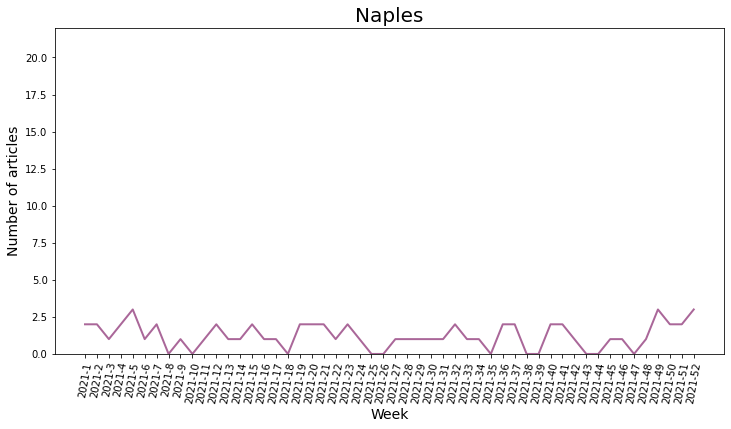

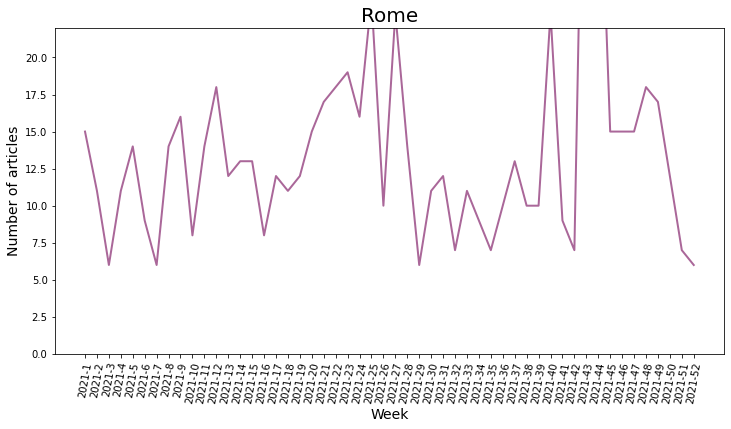

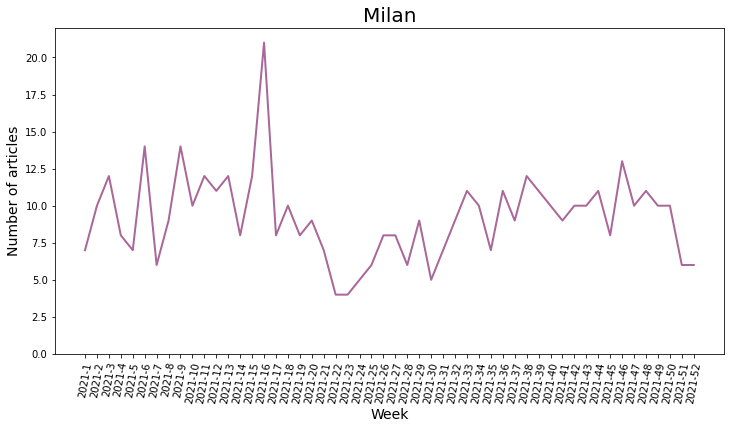

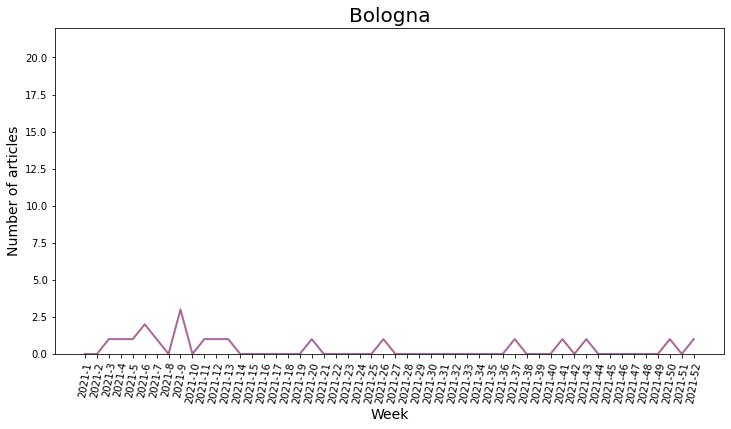

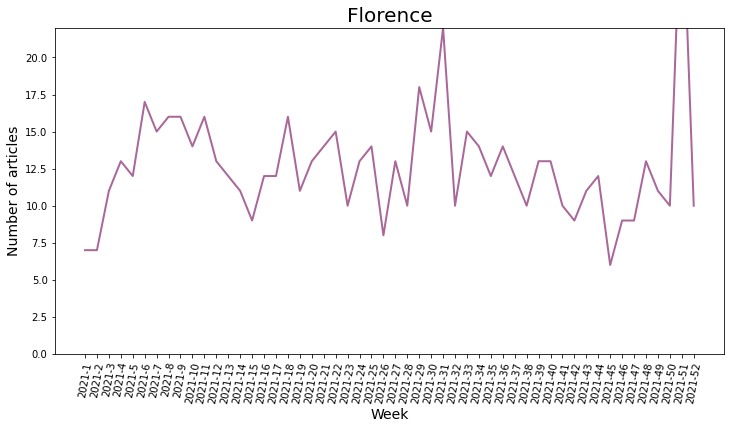

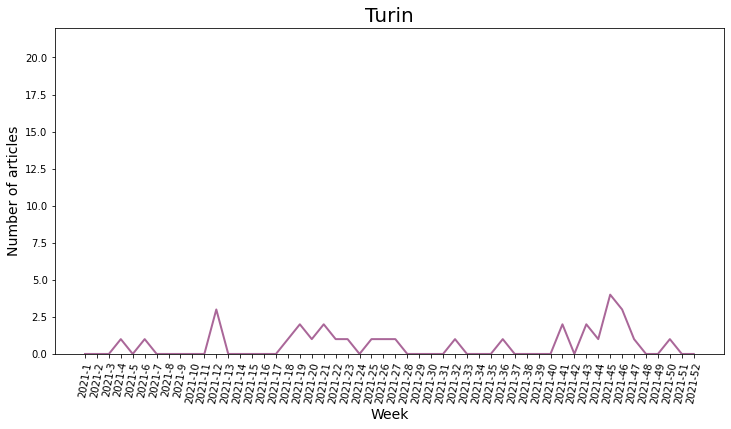

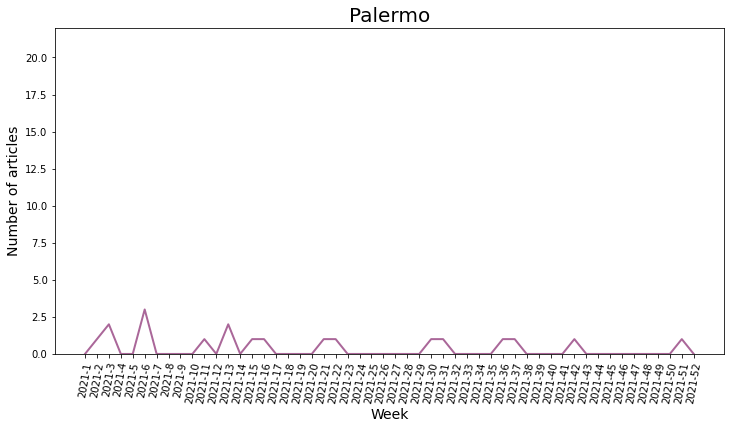

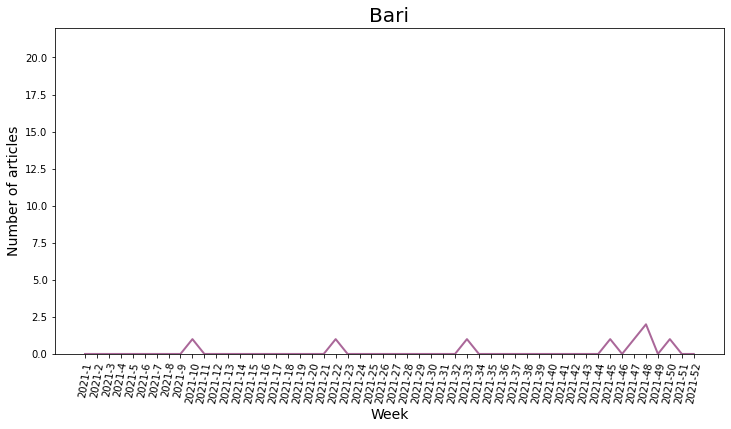

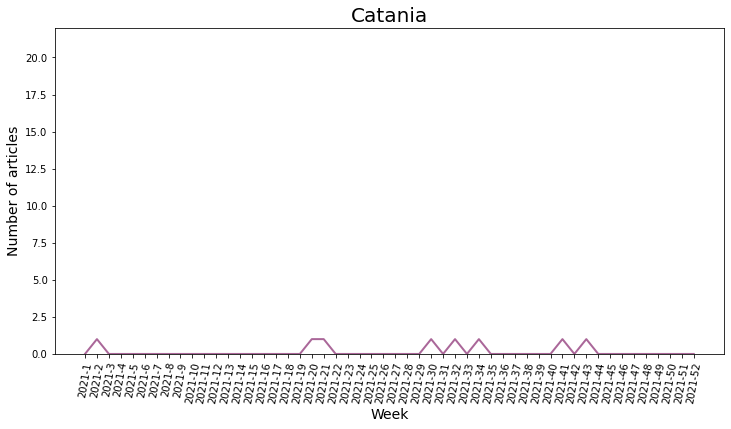

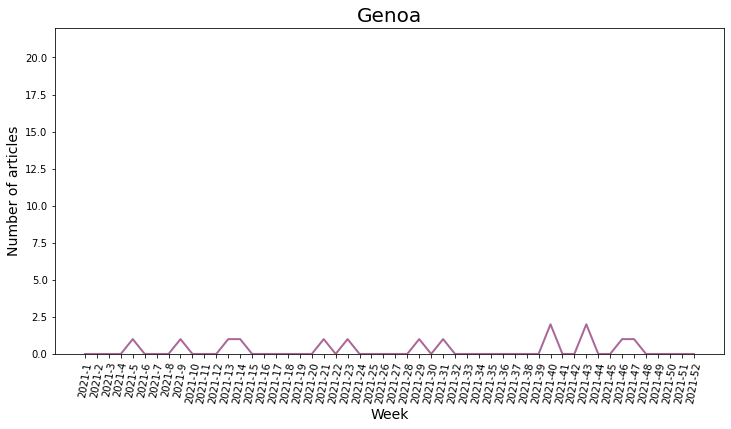

In [77]:
year = 2021
df_year = df.query( f'year=={year}' )

for city in cities:

    df_city = df_year.query( f'city=="{city.lower()}"' )
    counts = df_city.groupby('week')['year'].count().to_dict()
    
    x_axis = []
    y_axis = []
    for w in range(1,53):
        x_axis.append(f'{year}-{w}')
        y_axis.append(counts.get(w,0))

    fig = plt.figure( figsize = ( 12, 6))
    graph = sns.lineplot( x=x_axis , y=y_axis, 
                      color= '#AA6799', linestyle='solid',linewidth=2 )
    
    graph.set_title( city.title() , size = 20) 
    graph.set_xlabel('Week' , size = 14) 
    graph.set_ylabel('Number of articles' , size = 14 )
    
    plt.ylim(0,22)
    
    plt.xticks(rotation= 80)
    plt.show()
    

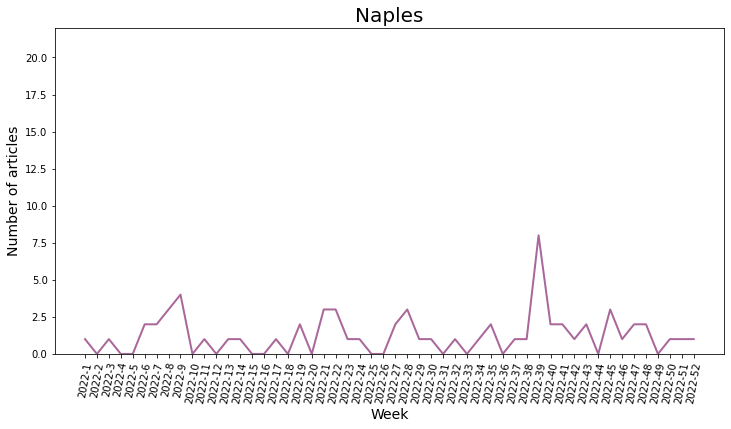

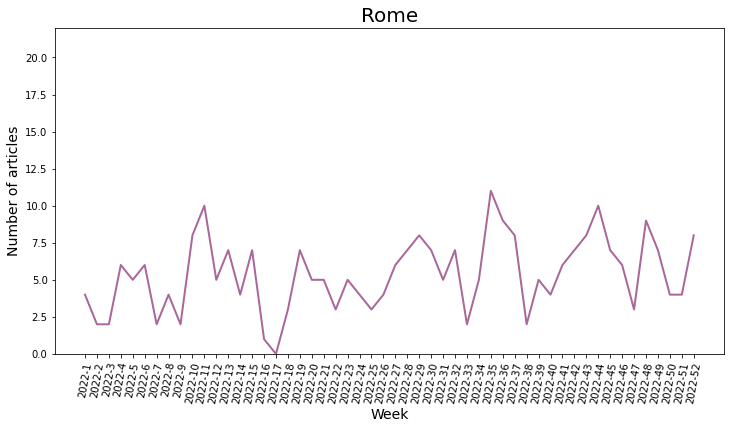

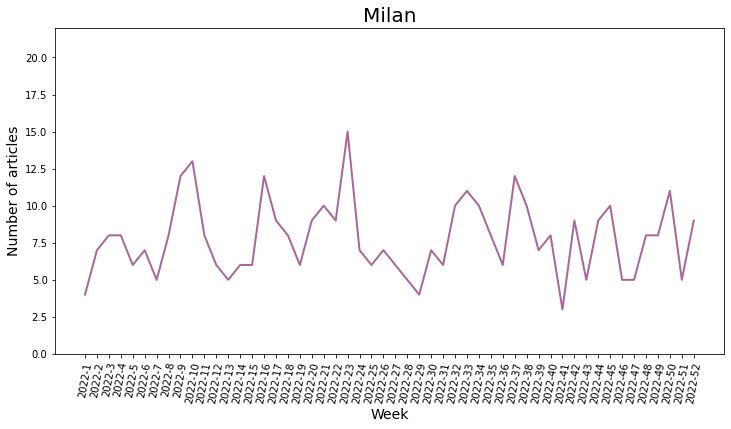

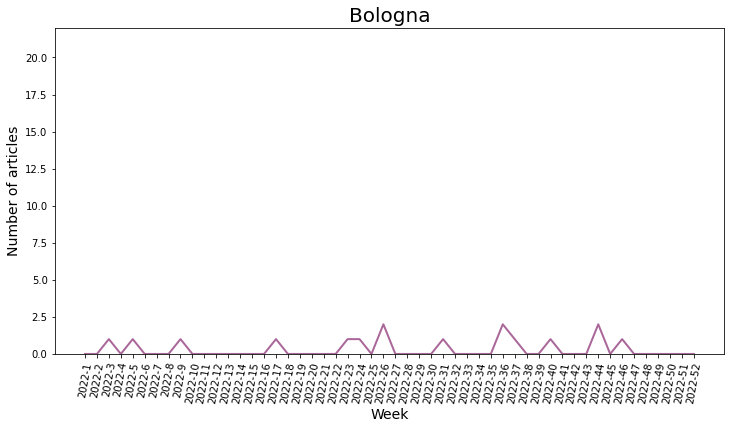

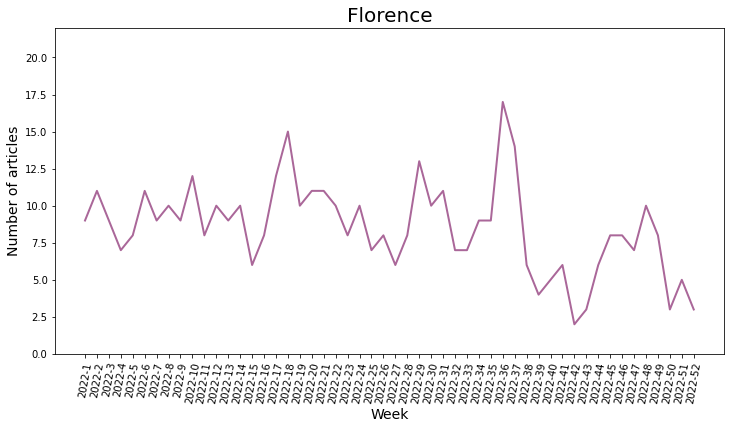

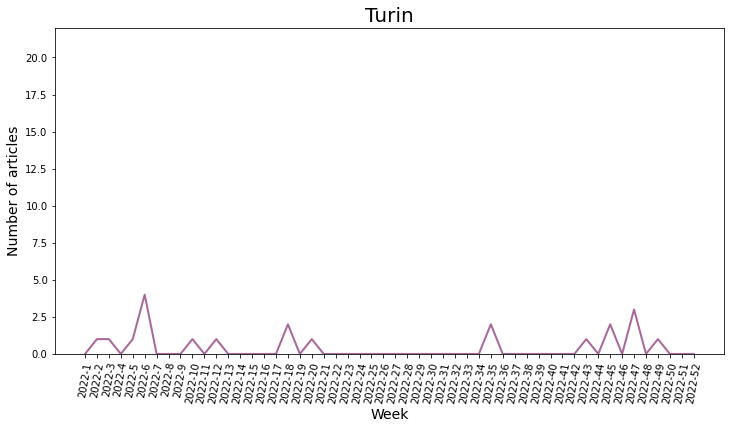

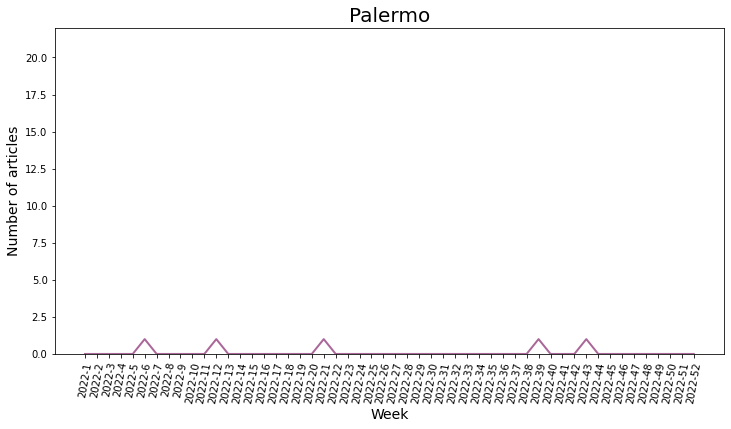

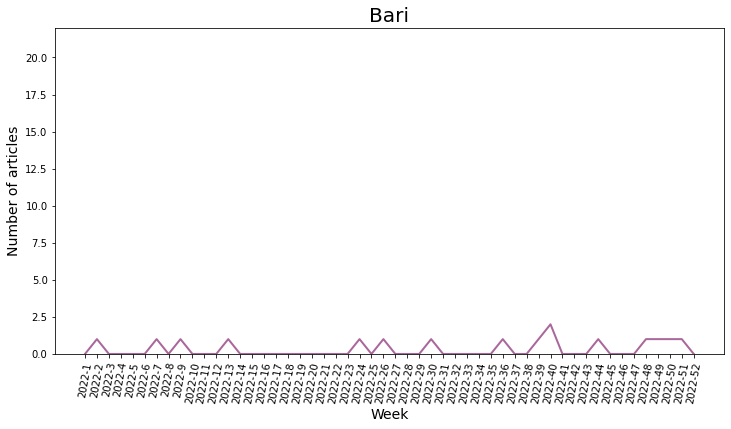

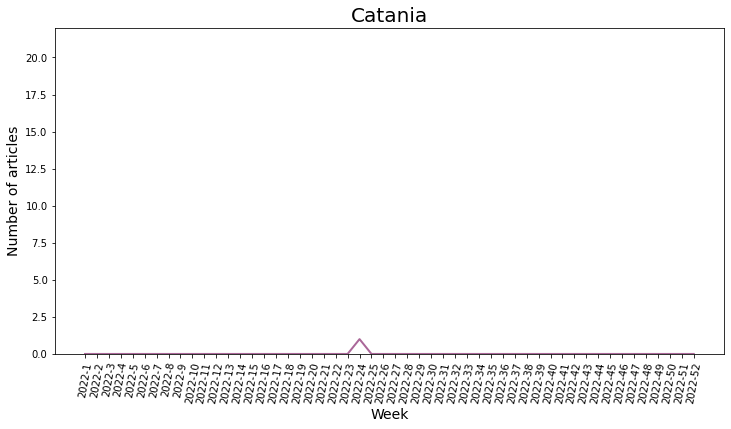

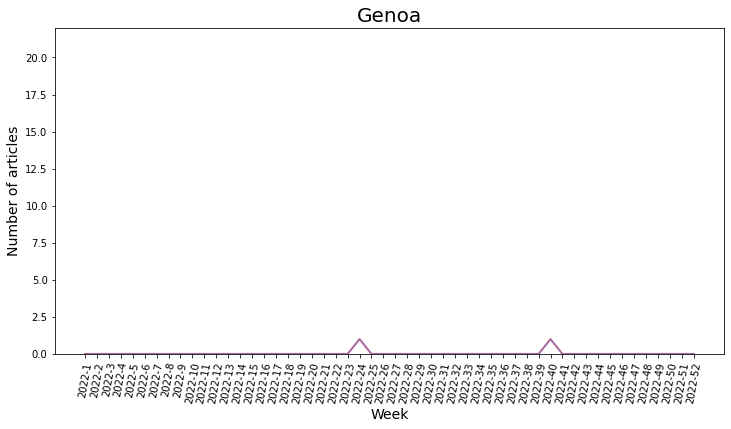

In [78]:
year = 2022
df_year = df.query( f'year=={year}' )

for city in cities:

    df_city = df_year.query( f'city=="{city.lower()}"' )
    counts = df_city.groupby('week')['year'].count().to_dict()
    
    x_axis = []
    y_axis = []
    for w in range(1,53):
        x_axis.append(f'{year}-{w}')
        y_axis.append(counts.get(w,0))

    fig = plt.figure( figsize = ( 12, 6))
    graph = sns.lineplot( x=x_axis , y=y_axis, 
                      color= '#AA6799', linestyle='solid',linewidth=2 )
    
    graph.set_title( city.title() , size = 20) 
    graph.set_xlabel('Week' , size = 14) 
    graph.set_ylabel('Number of articles' , size = 14 )
    
    plt.ylim(0,22)
    
    plt.xticks(rotation= 80)
    plt.show()
    

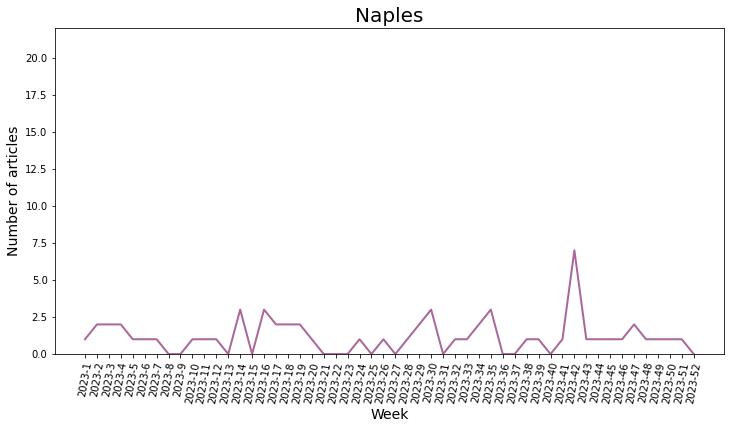

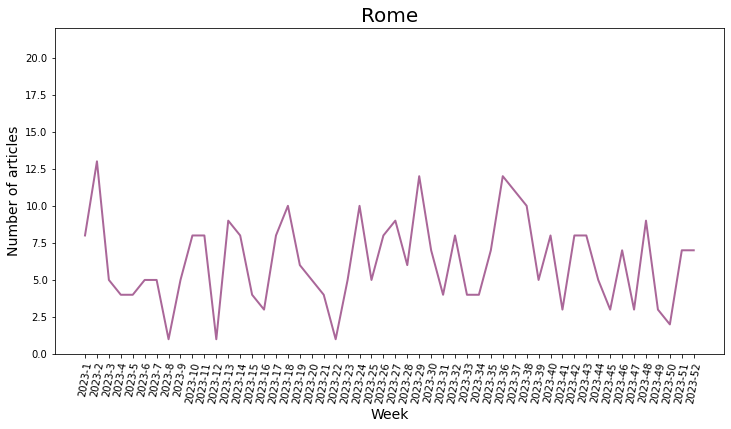

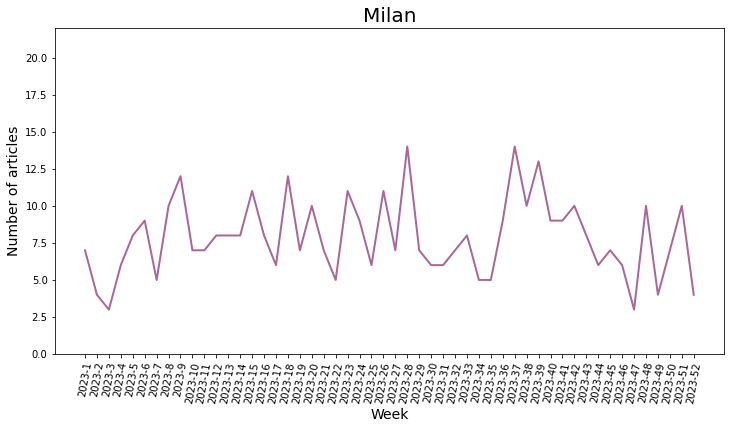

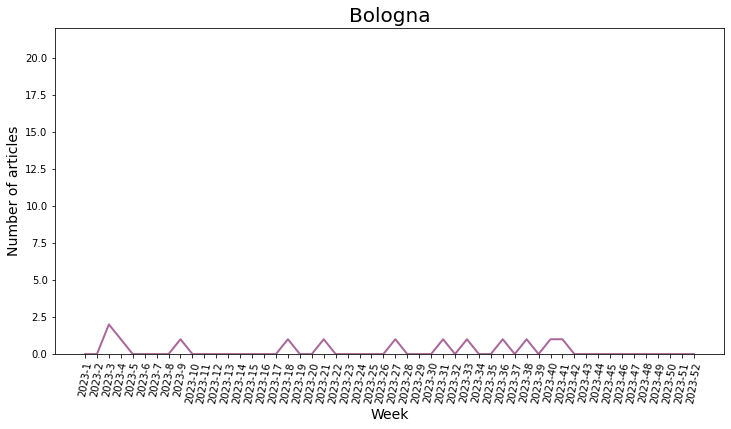

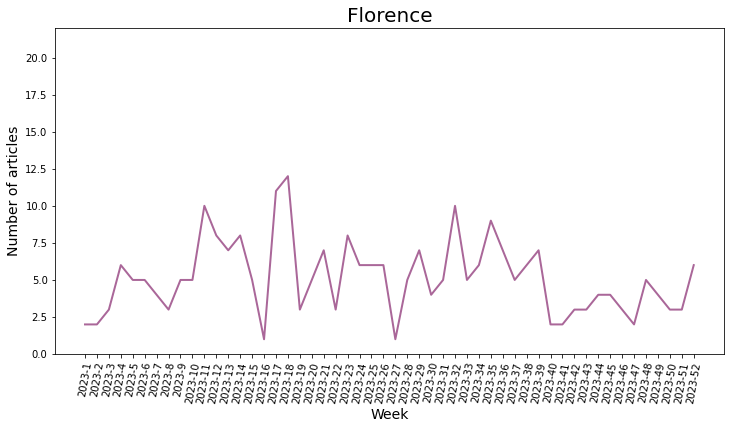

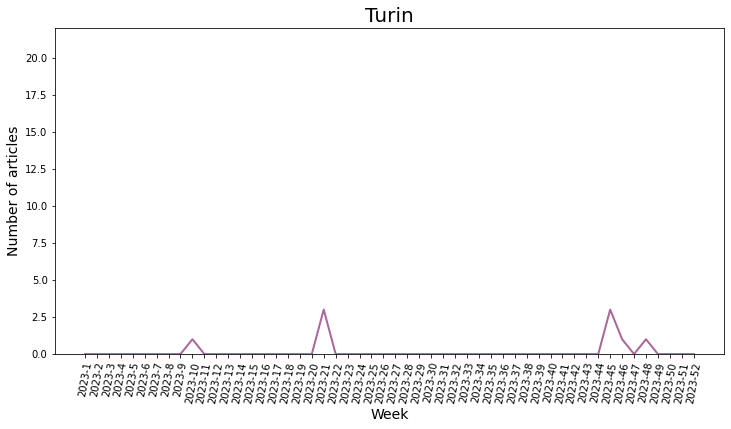

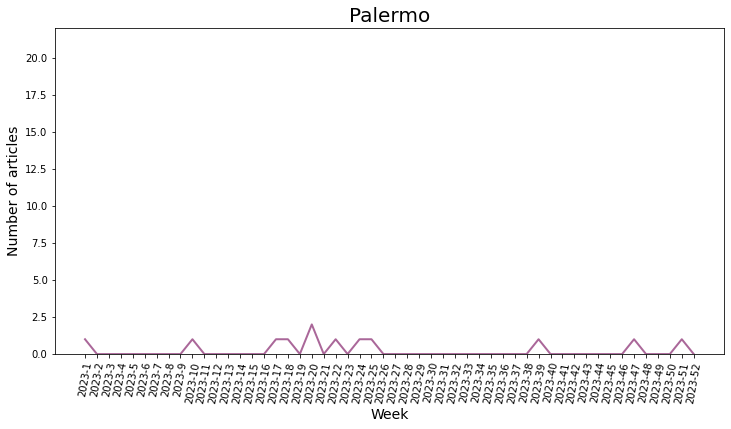

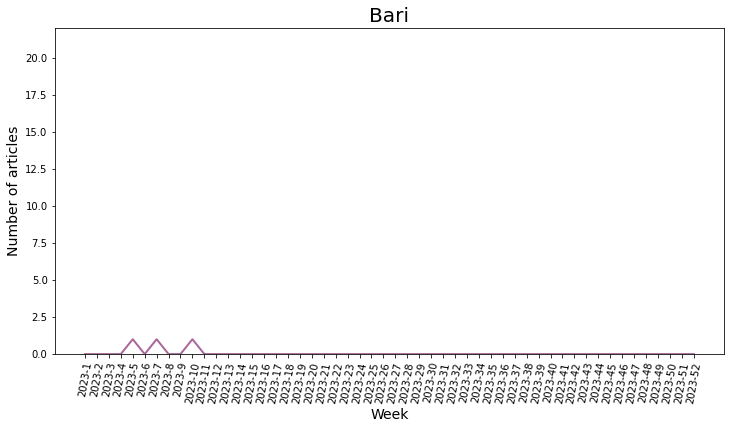

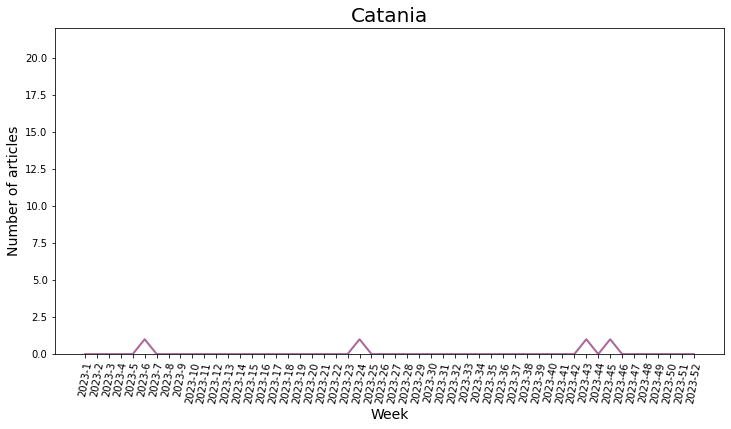

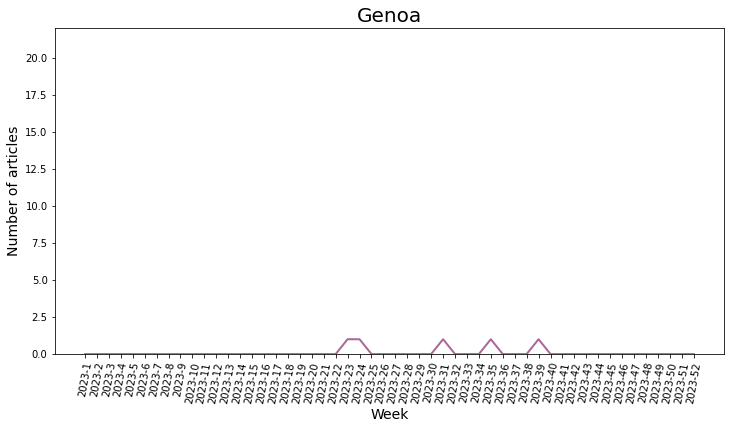

In [79]:
year = 2023
df_year = df.query( f'year=={year}' )

for city in cities:

    df_city = df_year.query( f'city=="{city.lower()}"' )
    counts = df_city.groupby('week')['year'].count().to_dict()
    
    x_axis = []
    y_axis = []
    for w in range(1,53):
        x_axis.append(f'{year}-{w}')
        y_axis.append(counts.get(w,0))

    fig = plt.figure( figsize = ( 12, 6))
    graph = sns.lineplot( x=x_axis , y=y_axis, 
                      color= '#AA6799', linestyle='solid',linewidth=2 )
    
    graph.set_title( city.title() , size = 20) 
    graph.set_xlabel('Week' , size = 14) 
    graph.set_ylabel('Number of articles' , size = 14 )
    
    plt.ylim(0,22)
    
    plt.xticks(rotation= 80)
    plt.show()
    

## Which words are used most frequently in articles on these Italian cities?

In [81]:
year = 2023
df_year = df.query( f'year=={year}' )

for city in cities:
    
    freq = Counter()
    print(f'\n\n{city.title()}\n\n')
    
    df_articles = df_year.query( f'city=="{city.lower()}"' )
    for path in df_articles['path']:
        with open(path) as fh:
            article = json.load(fh)
            full_text = article['abstract']
            full_text += ' ' + article['main_headline']
            words = word_tokenize(full_text.lower())
            words = [word for word in words if word not in stopword_list]
            words = [word for word in words if word != city]
            freq.update(words)
    
    for word,count in freq.most_common(30):
        print(f'{word}\t({count})')



Naples


new	(11)
florida	(8)
desantis	(6)
one	(6)
people	(5)
dies	(5)
also	(4)
world	(4)
job	(4)
fashion	(4)
art	(4)
health	(4)
state	(4)
china	(4)
briefing	(4)
readers	(3)
said	(3)
even	(3)
women	(3)
appear	(3)
face	(3)
like	(3)
finding	(3)
toward	(3)
hurricane	(3)
trip	(3)
best	(3)
imported	(3)
something	(3)
ron	(3)


Rome


new	(60)
pope	(34)
francis	(31)
also	(28)
ukraine	(24)
briefing	(22)
first	(22)
one	(22)
u.s.	(22)
york	(18)
says	(17)
history	(17)
russia	(16)
week	(15)
like	(15)
said	(15)
work	(15)
american	(15)
year	(14)
world	(14)
war	(14)
time	(13)
art	(12)
dies	(12)
us	(12)
russian	(12)
people	(12)
church	(12)
say	(12)
climate	(12)


Milan


new	(67)
president	(39)
u.s.	(28)
biden	(27)
trump	(25)
could	(25)
ukraine	(24)
fashion	(23)
war	(22)
many	(19)
court	(19)
inside	(18)
times	(18)
house	(18)
government	(17)
former	(17)
city	(17)
one	(17)
country	(17)
two	(17)
republican	(16)
china	(15)
york	(15)
people	(15)
also	(14)
years	(14)
crisis	(14)
story	(13)
supreme	(13)
we

In [83]:
year = 2022
df_year = df.query( f'year=={year}' )

for city in cities:
    
    freq = Counter()
    print(f'\n\n{city.title()}\n\n')
    
    df_articles = df_year.query( f'city=="{city.lower()}"' )
    for path in df_articles['path']:
        with open(path) as fh:
            article = json.load(fh)
            full_text = article['abstract']
            full_text += ' ' + article['main_headline']
            words = word_tokenize(full_text.lower())
            words = [word for word in words if word not in stopword_list]
            words = [word for word in words if word != city]
            freq.update(words)
    
    for word,count in freq.most_common(30):
        print(f'{word}\t({count})')





Naples


florida	(19)
ian	(12)
hurricane	(11)
storm	(10)
trump	(9)
new	(8)
dies	(7)
first	(6)
state	(6)
southwest	(5)
coast	(5)
made	(5)
life	(5)
like	(5)
desantis	(5)
county	(5)
long	(5)
golf	(5)
around	(4)
hit	(4)
ron	(4)
one	(4)
met	(4)
could	(4)
former	(4)
u.s.	(4)
residents	(4)
big	(3)
museum	(3)
york	(3)


Rome


ukraine	(42)
new	(40)
russia	(31)
pope	(28)
war	(27)
world	(24)
china	(23)
dies	(17)
briefing	(17)
year	(16)
time	(15)
u.s.	(15)
francis	(14)
people	(14)
make	(14)
years	(14)
one	(13)
first	(13)
russian	(12)
day	(12)
two	(12)
biden	(11)
home	(11)
president	(11)
may	(11)
show	(11)
back	(10)
said	(10)
country	(10)
also	(10)


Milan


new	(55)
ukraine	(45)
russia	(31)
war	(28)
could	(28)
one	(27)
president	(25)
u.s.	(24)
fashion	(24)
putin	(24)
two	(21)
world	(21)
court	(19)
abortion	(18)
york	(17)
first	(17)
city	(17)
america	(16)
russian	(16)
like	(16)
state	(16)
political	(16)
trump	(15)
big	(15)
supreme	(15)
years	(14)
united	(14)
states	(14)
v.	(14)
invasion	(14)


B

In [84]:
year = 2023
df_year = df.query( f'year=={year}' )

for city in cities:
    
    freq = Counter()
    print(f'\n\n{city.title()}\n\n')
    
    df_articles = df_year.query( f'city=="{city.lower()}"' )
    for path in df_articles['path']:
        with open(path) as fh:
            article = json.load(fh)
            full_text = article['abstract']
            full_text += ' ' + article['main_headline']
            words = word_tokenize(full_text.lower())
            words = [word for word in words if word not in stopword_list]
            words = [word for word in words if word != city]
            freq.update(words)
    
    for word,count in freq.most_common(30):
        print(f'{word}\t({count})')





Naples


new	(11)
florida	(8)
desantis	(6)
one	(6)
people	(5)
dies	(5)
also	(4)
world	(4)
job	(4)
fashion	(4)
art	(4)
health	(4)
state	(4)
china	(4)
briefing	(4)
readers	(3)
said	(3)
even	(3)
women	(3)
appear	(3)
face	(3)
like	(3)
finding	(3)
toward	(3)
hurricane	(3)
trip	(3)
best	(3)
imported	(3)
something	(3)
ron	(3)


Rome


new	(60)
pope	(34)
francis	(31)
also	(28)
ukraine	(24)
briefing	(22)
first	(22)
one	(22)
u.s.	(22)
york	(18)
says	(17)
history	(17)
russia	(16)
week	(15)
like	(15)
said	(15)
work	(15)
american	(15)
year	(14)
world	(14)
war	(14)
time	(13)
art	(12)
dies	(12)
us	(12)
russian	(12)
people	(12)
church	(12)
say	(12)
climate	(12)


Milan


new	(67)
president	(39)
u.s.	(28)
biden	(27)
trump	(25)
could	(25)
ukraine	(24)
fashion	(23)
war	(22)
many	(19)
court	(19)
inside	(18)
times	(18)
house	(18)
government	(17)
former	(17)
city	(17)
one	(17)
country	(17)
two	(17)
republican	(16)
china	(15)
york	(15)
people	(15)
also	(14)
years	(14)
crisis	(14)
story	(13)
supreme	(13)
we